In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import random
import struct
import subprocess
import sys
from matplotlib.patches import Rectangle

In [2]:
base_dir = os.getcwd()
exec_dir = '..'

---
# Print root rectangles

(460, 758, 16371, 8191)
(427, 4109, 16383, 16376)
(8192, 0, 29687, 16367)
(517, 6, 29991, 17339)
(191, 16403, 16370, 28671)
(0, 16403, 24563, 29999)
(16384, 16406, 29233, 29808)
(24610, 24587, 29999, 29995)


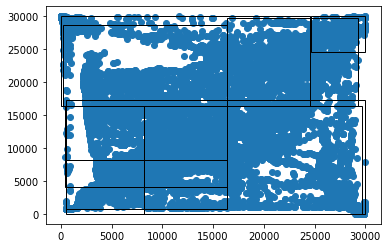

In [3]:
input_file = 'data/morton_data.csv'
c = 16
params = ['../TestIndex', input_file, str(c)]
p = subprocess.run(params, capture_output=True, check=True)
df = pd.read_csv(input_file)
rects = pd.read_csv('rectangles.csv')
plt.scatter(df.rx, df.ry)
for index, row in rects.iterrows():
    r = (row.lx, row.ly, row.ux, row.uy)
    print(r)
    plt.gca().add_patch(Rectangle((r[0], r[1]), r[2]-r[0], r[3]-r[1], fill=None, alpha=1))

---
# Queries with Morton index

In [3]:
data_file = 'data/crash_data_30000.csv'
output_data = 'data/morton_data.csv'
data = pd.read_csv(data_file)
data.head()

,ID,Year,Month,Day,Time,x,y
0,2013-8658-27/05/2021,2013,June,Saturday,03:20 pm,131841249,165248777
1,2013-7593-27/05/2021,2013,June,Saturday,05:53 pm,131871919,168051524
2,2017-10634-27/05/2021,2017,October,Saturday,02:00 pm,129817670,176454696
3,2013-5415-27/05/2021,2013,April,Wednesday,12:45 am,132103890,166434695
4,2015-11343-27/05/2021,2015,September,Thursday,11:15 am,133743698,168099472


In [4]:
sx = data['x'].sort_values().reset_index(drop = True)
sy = data['y'].sort_values().reset_index(drop = True)
xmap = dict((v,k) for k,v in sx.iteritems())
ymap = dict((v,k) for k,v in sy.iteritems())
def xrank(v): return xmap[v]
def yrank(v): return ymap[v]
data['rx'] = data['x'].apply(xrank)
data['ry'] = data['y'].apply(yrank)
data.to_csv(output_data, index=False)
data.head()

,ID,Year,Month,Day,Time,x,y,rx,ry
0,2013-8658-27/05/2021,2013,June,Saturday,03:20 pm,131841249,165248777,2421,3586
1,2013-7593-27/05/2021,2013,June,Saturday,05:53 pm,131871919,168051524,2592,21388
2,2017-10634-27/05/2021,2017,October,Saturday,02:00 pm,129817670,176454696,1473,28680
3,2013-5415-27/05/2021,2013,April,Wednesday,12:45 am,132103890,166434695,4636,7239
4,2015-11343-27/05/2021,2015,September,Thursday,11:15 am,133743698,168099472,24933,21698


In [5]:
def map_lower_x(lx): 
    return np.min(data[data.x >= lx]['rx'])
def map_lower_y(ly): 
    return np.min(data[data.y >= ly]['ry'])
def map_upper_x(ux): 
    return np.max(data[data.x <= ux]['rx'])
def map_upper_y(uy): 
    return np.max(data[data.y <= uy]['ry'])

In [6]:
for f in range(1, 10):
    query_file = 'data/random_queries_{}.csv'.format(f*10)
    output_query = 'data/morton_queries_{}.csv'.format(f*10)
    queries = pd.read_csv(query_file)
    queries['rlx'] = queries['lx'].apply(map_lower_x)
    queries['rly'] = queries['ly'].apply(map_lower_y)
    queries['rux'] = queries['ux'].apply(map_upper_x)
    queries['ruy'] = queries['uy'].apply(map_upper_y)
    queries.to_csv(output_query, index=False)
    
print('Done!')

Done!


In [4]:
c=16
input_file = '{}/data/morton_data.csv'.format(base_dir)
output_file = '{}/test_query_verification/morton_fraction.csv'.format(base_dir)
f = open(output_file, 'w')
f.write('fraction,avg_returned,avg_matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for i in range(1, 10):
    print('Testing fraction = {}%...'.format(i*10))
    query_file = '{}/data/morton_queries_{}.csv'.format(base_dir, i*10)
    params = ['./TestQuery', input_file, query_file, str(c)]
    p = subprocess.run(params, capture_output=True, check=True)
    lines = p.stdout.decode('utf-8').splitlines()
    avg_retur = int((lines[1].split(':'))[1])
    avg_match = int((lines[2].split(':'))[1])
    avg_query = int((lines[3].split(':'))[1])
    avg_verif = int((lines[4].split(':'))[1])
    f.write('{},{},{},{},{}\n'.format(i*10,avg_retur,avg_match,avg_query,avg_verif))
    
f.close()

os.chdir(base_dir)
print('Done!')

Testing fraction = 10%...
Testing fraction = 20%...
Testing fraction = 30%...
Testing fraction = 40%...
Testing fraction = 50%...
Testing fraction = 60%...
Testing fraction = 70%...
Testing fraction = 80%...
Testing fraction = 90%...
Done!


In [5]:
df=pd.read_csv('test_query_verification/morton_fraction.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'fraction':str, 'avg_returned': int, 'avg_matching': int})
df['noise'] = 1-(df['avg_matching']/df['avg_returned'])
#df['noise'] = (df['avg_returned']-df['avg_matching'])/(df['avg_returned']-2*df['avg_matching']+30000)
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'noise':3, 'avg_query': 3, 'avg_verif': 3})
# Reorder columns.
df = df[['fraction','avg_returned','avg_matching','noise','avg_query','avg_verif']]
print(df.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
fraction &  avg\_returned &  avg\_matching &  noise &  avg\_query &  avg\_verif \\
\midrule
      10 &          5699 &          3006 &  0.473 &      0.777 &      5.463 \\
      20 &          8890 &          5970 &  0.328 &      1.255 &      9.414 \\
      30 &         12300 &          8982 &  0.270 &      1.721 &     13.383 \\
      40 &         14789 &         12009 &  0.188 &      2.077 &     17.061 \\
      50 &         17501 &         15007 &  0.143 &      2.458 &     20.813 \\
      60 &         21471 &         18011 &  0.161 &      3.098 &     25.718 \\
      70 &         24153 &         21000 &  0.131 &      3.492 &     29.754 \\
      80 &         26485 &         23997 &  0.094 &      3.786 &     32.885 \\
      90 &         29125 &         27072 &  0.070 &      4.129 &     36.111 \\
\bottomrule
\end{tabular}



---


In [9]:
for f in range(1, 10):
    query_file = 'data/random_queries_{}.csv'.format(f)
    output_query = 'data/morton_queries_{}.csv'.format(f)
    queries = pd.read_csv(query_file)
    queries['rlx'] = queries['lx'].apply(map_lower_x)
    queries['rly'] = queries['ly'].apply(map_lower_y)
    queries['rux'] = queries['ux'].apply(map_upper_x)
    queries['ruy'] = queries['uy'].apply(map_upper_y)
    queries.to_csv(output_query, index=False)
    
print('Done!')

Done!


In [8]:
c=16
input_file = '{}/data/morton_data.csv'.format(base_dir)
output_file = '{}/test_query_verification/morton_fraction_low.csv'.format(base_dir)
f = open(output_file, 'w')
f.write('fraction,avg_returned,avg_matching,avg_query,avg_verif\n')

os.chdir(exec_dir)

for i in range(1, 10):
    print('Testing fraction = {}%...'.format(i))
    query_file = '{}/data/morton_queries_{}.csv'.format(base_dir, i)
    params = ['./TestQuery', input_file, query_file, str(c)]
    p = subprocess.run(params, capture_output=True, check=True)
    lines = p.stdout.decode('utf-8').splitlines()
    avg_retur = int((lines[1].split(':'))[1])
    avg_match = int((lines[2].split(':'))[1])
    avg_query = int((lines[3].split(':'))[1])
    avg_verif = int((lines[4].split(':'))[1])
    f.write('{},{},{},{},{}\n'.format(i,avg_retur,avg_match,avg_query,avg_verif))
    
f.close()

os.chdir(base_dir)
print('Done!')

Testing fraction = 1%...
Testing fraction = 2%...
Testing fraction = 3%...
Testing fraction = 4%...
Testing fraction = 5%...
Testing fraction = 6%...
Testing fraction = 7%...
Testing fraction = 8%...
Testing fraction = 9%...
Done!


In [9]:
df=pd.read_csv('test_query_verification/morton_fraction_low.csv')
# Convert returned and matching columns to integer type.
df = df.astype({'fraction':str, 'avg_returned': int, 'avg_matching': int})
df['noise'] = 1-(df['avg_matching']/df['avg_returned'])
# Divide by 1000 to convert microseconds to milliseconds.
df['avg_query'] /= 1000
df['avg_verif'] /= 1000
# Round the execution times to 3 decimal places.
df = df.round({'noise':3, 'avg_query': 3, 'avg_verif': 3})
# Reorder columns.
df = df[['fraction','avg_returned','avg_matching','noise','avg_query','avg_verif']]
print(df.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
fraction &  avg\_returned &  avg\_matching &  noise &  avg\_query &  avg\_verif \\
\midrule
       1 &          2572 &           299 &  0.884 &      0.331 &      1.685 \\
       2 &          2537 &           598 &  0.764 &      0.376 &      2.053 \\
       3 &          3195 &           897 &  0.719 &      0.446 &      2.529 \\
       4 &          3488 &          1201 &  0.656 &      0.487 &      2.839 \\
       5 &          4110 &          1499 &  0.635 &      0.562 &      3.378 \\
       6 &          4407 &          1800 &  0.592 &      0.615 &      3.778 \\
       7 &          4778 &          2101 &  0.560 &      0.678 &      4.216 \\
       8 &          5052 &          2400 &  0.525 &      0.707 &      4.608 \\
       9 &          5413 &          2699 &  0.501 &      0.766 &      5.031 \\
\bottomrule
\end{tabular}

